In [1]:
import math
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import re
import seaborn as sns
import time
import warnings

from sklearn.datasets import make_classification
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, make_scorer, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

from scipy.cluster.hierarchy import linkage, dendrogram
from pygam import LinearGAM

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/obbrown1/Unsupervised_Final/main/train.csv')

<font size="6">Problem Statement</font>

I am using the data set from the kaggle competition "ICR - Identifying Age-Related Conditions". My goal is to build a binary classifier to predict if a person "person has one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0)." The training data consists of an Id column, a target column ('Class'), and 56 columns representating anonymized health characteristics. Due to the anonymous nature of the features, and the fact that I have no medical expertise, I will have to rely more heavily on unsupervised and domain-agnostic methods of analysis. I will create a number of different models, both supervised and unsupervised, and compare their performance, along the dimensions of training time, run time, and accuracy.  

https://www.kaggle.com/competitions/icr-identify-age-related-conditions

# EDA  

### Field Descriptions
- **Id**: Unique identifier for each observation.
- **AB-GL**: Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical  
- **Class**: A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicate
 they have not.

### EDA Procedure 
- Inspect data.
- Check for missing or null values.
- Fix missing values by imputing column means.
- Encode EJ, transform letters to numbers.
- Normalize by column.
- Use hierarchical clustering to combine highly correlated columns.

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
data = data.drop(['Id'], axis=1)

# Check for empty values
empty_columns = data.columns[data.isnull().all()]
print("Empty columns:", empty_columns)

# Check for null values
null_columns = data.columns[data.isnull().any()]
print("Null columns:", null_columns)

# Check for NaN values
nan_columns = data.columns[data.isna().any()]
print("NaN columns:", nan_columns)

# Check for missing values
missing_columns = data.columns[data.isnull().any() | data.isna().any()]
print("Missing value columns:", missing_columns)

Empty columns: Index([], dtype='object')
Null columns: Index(['BQ', 'CB', 'CC', 'DU', 'EL', 'FC', 'FL', 'FS', 'GL'], dtype='object')
NaN columns: Index(['BQ', 'CB', 'CC', 'DU', 'EL', 'FC', 'FL', 'FS', 'GL'], dtype='object')
Missing value columns: Index(['BQ', 'CB', 'CC', 'DU', 'EL', 'FC', 'FL', 'FS', 'GL'], dtype='object')


In [5]:
count = data.isna().any(axis=1).sum()
count / len(data)

0.11183144246353323

### Missing Values
Rows with at least one missing value represent 11% of the total number of rows. Since this is already a small data set, instead of removing those rows, I will replace the missing values with the mean of their respective columns.

### Data Visualization

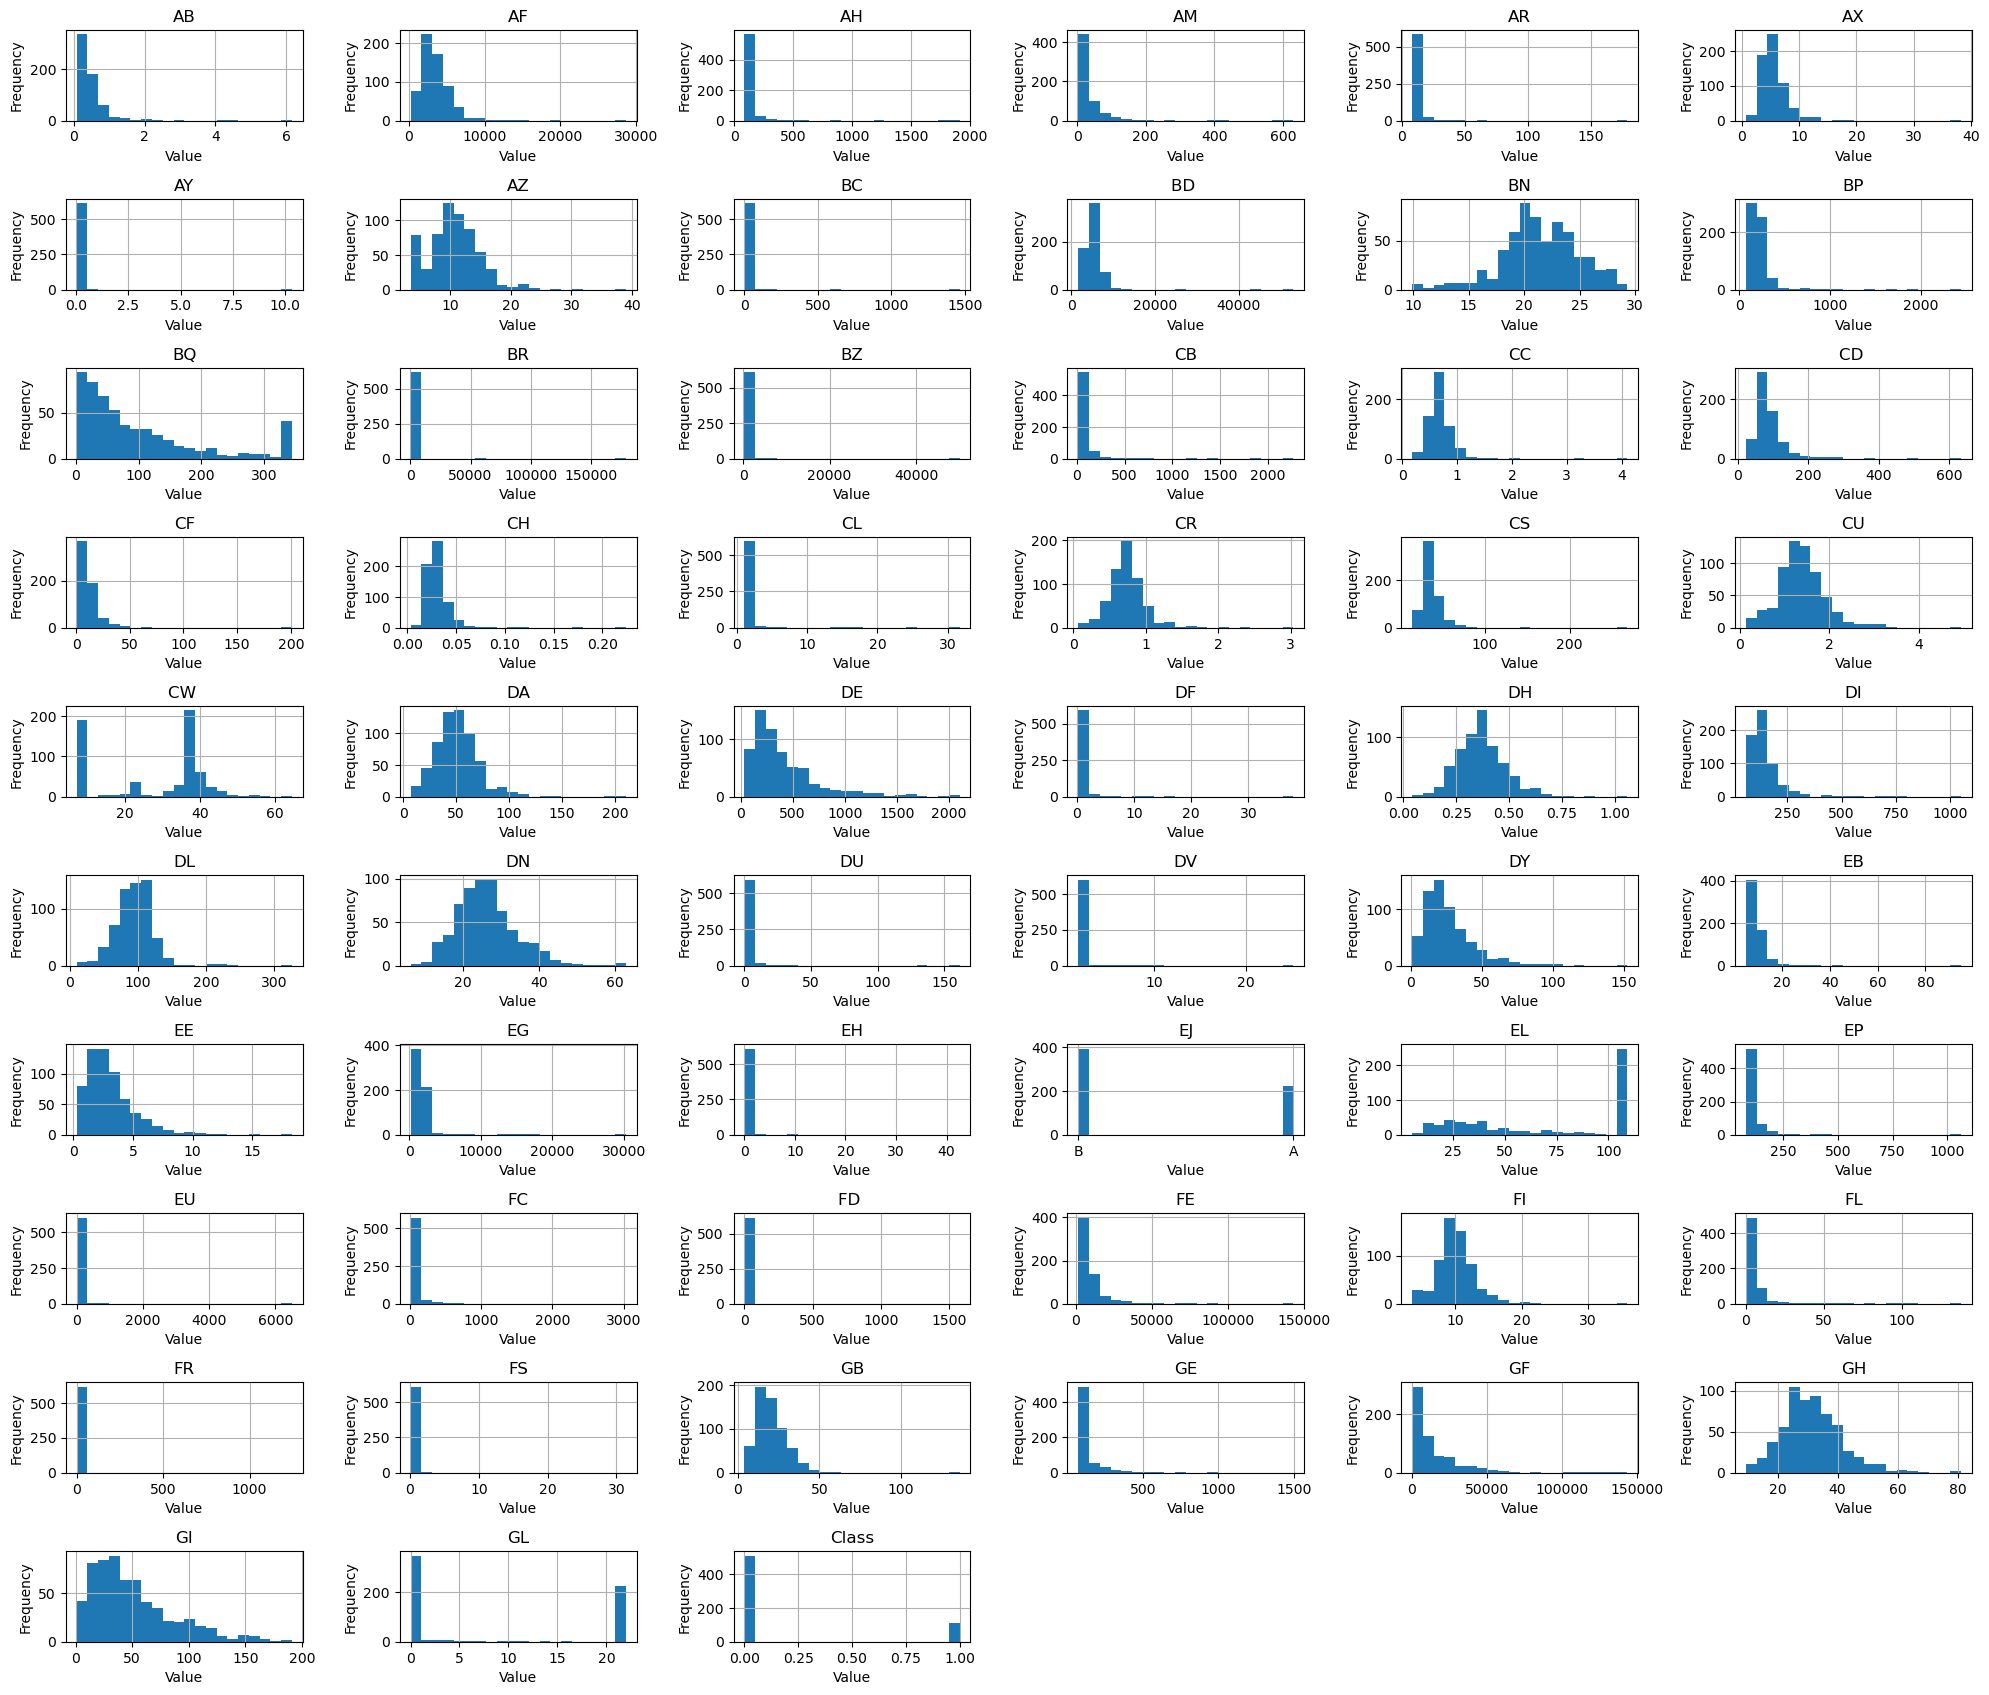

In [6]:
fig, axes = plt.subplots(12, 6, figsize=(20, 20))
axes = axes.flatten()
num_cols = len(data.columns)

for i, column in enumerate(data.columns):
    ax = axes[i]
    data[column].hist(ax=ax, bins=20)
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

if num_cols < len(axes):
    for j in range(num_cols, len(axes)):
        axes[j].set_visible(False)

fig.tight_layout()
plt.show()

Many of the features that appear to be very tightly clustered around a single value actually have extreme outliers that greatly expand the range of the data and therefore compress the bulk of it to one side of the distribution. I will replace the top and bottom 5% of values to correct with median values to correct for this.

It may be the case that the outlying values are significant, but because the features are anonymized health measures, it is hard to say for certain whether they are significant or simply bad data.

In [7]:
le = LabelEncoder()
data['EJ'] = le.fit_transform(data['EJ'])
data = data.fillna(data.mean())

In [8]:
#replace outliers (top and bottom 5%) with column median
for column in data.columns:
    med = data[column].median()
    top = data[column].quantile(0.95)
    bottom = data[column].quantile(0.05)
    condition = (data[column] > top) | (data[column] < bottom)
    data.loc[condition, column] = med

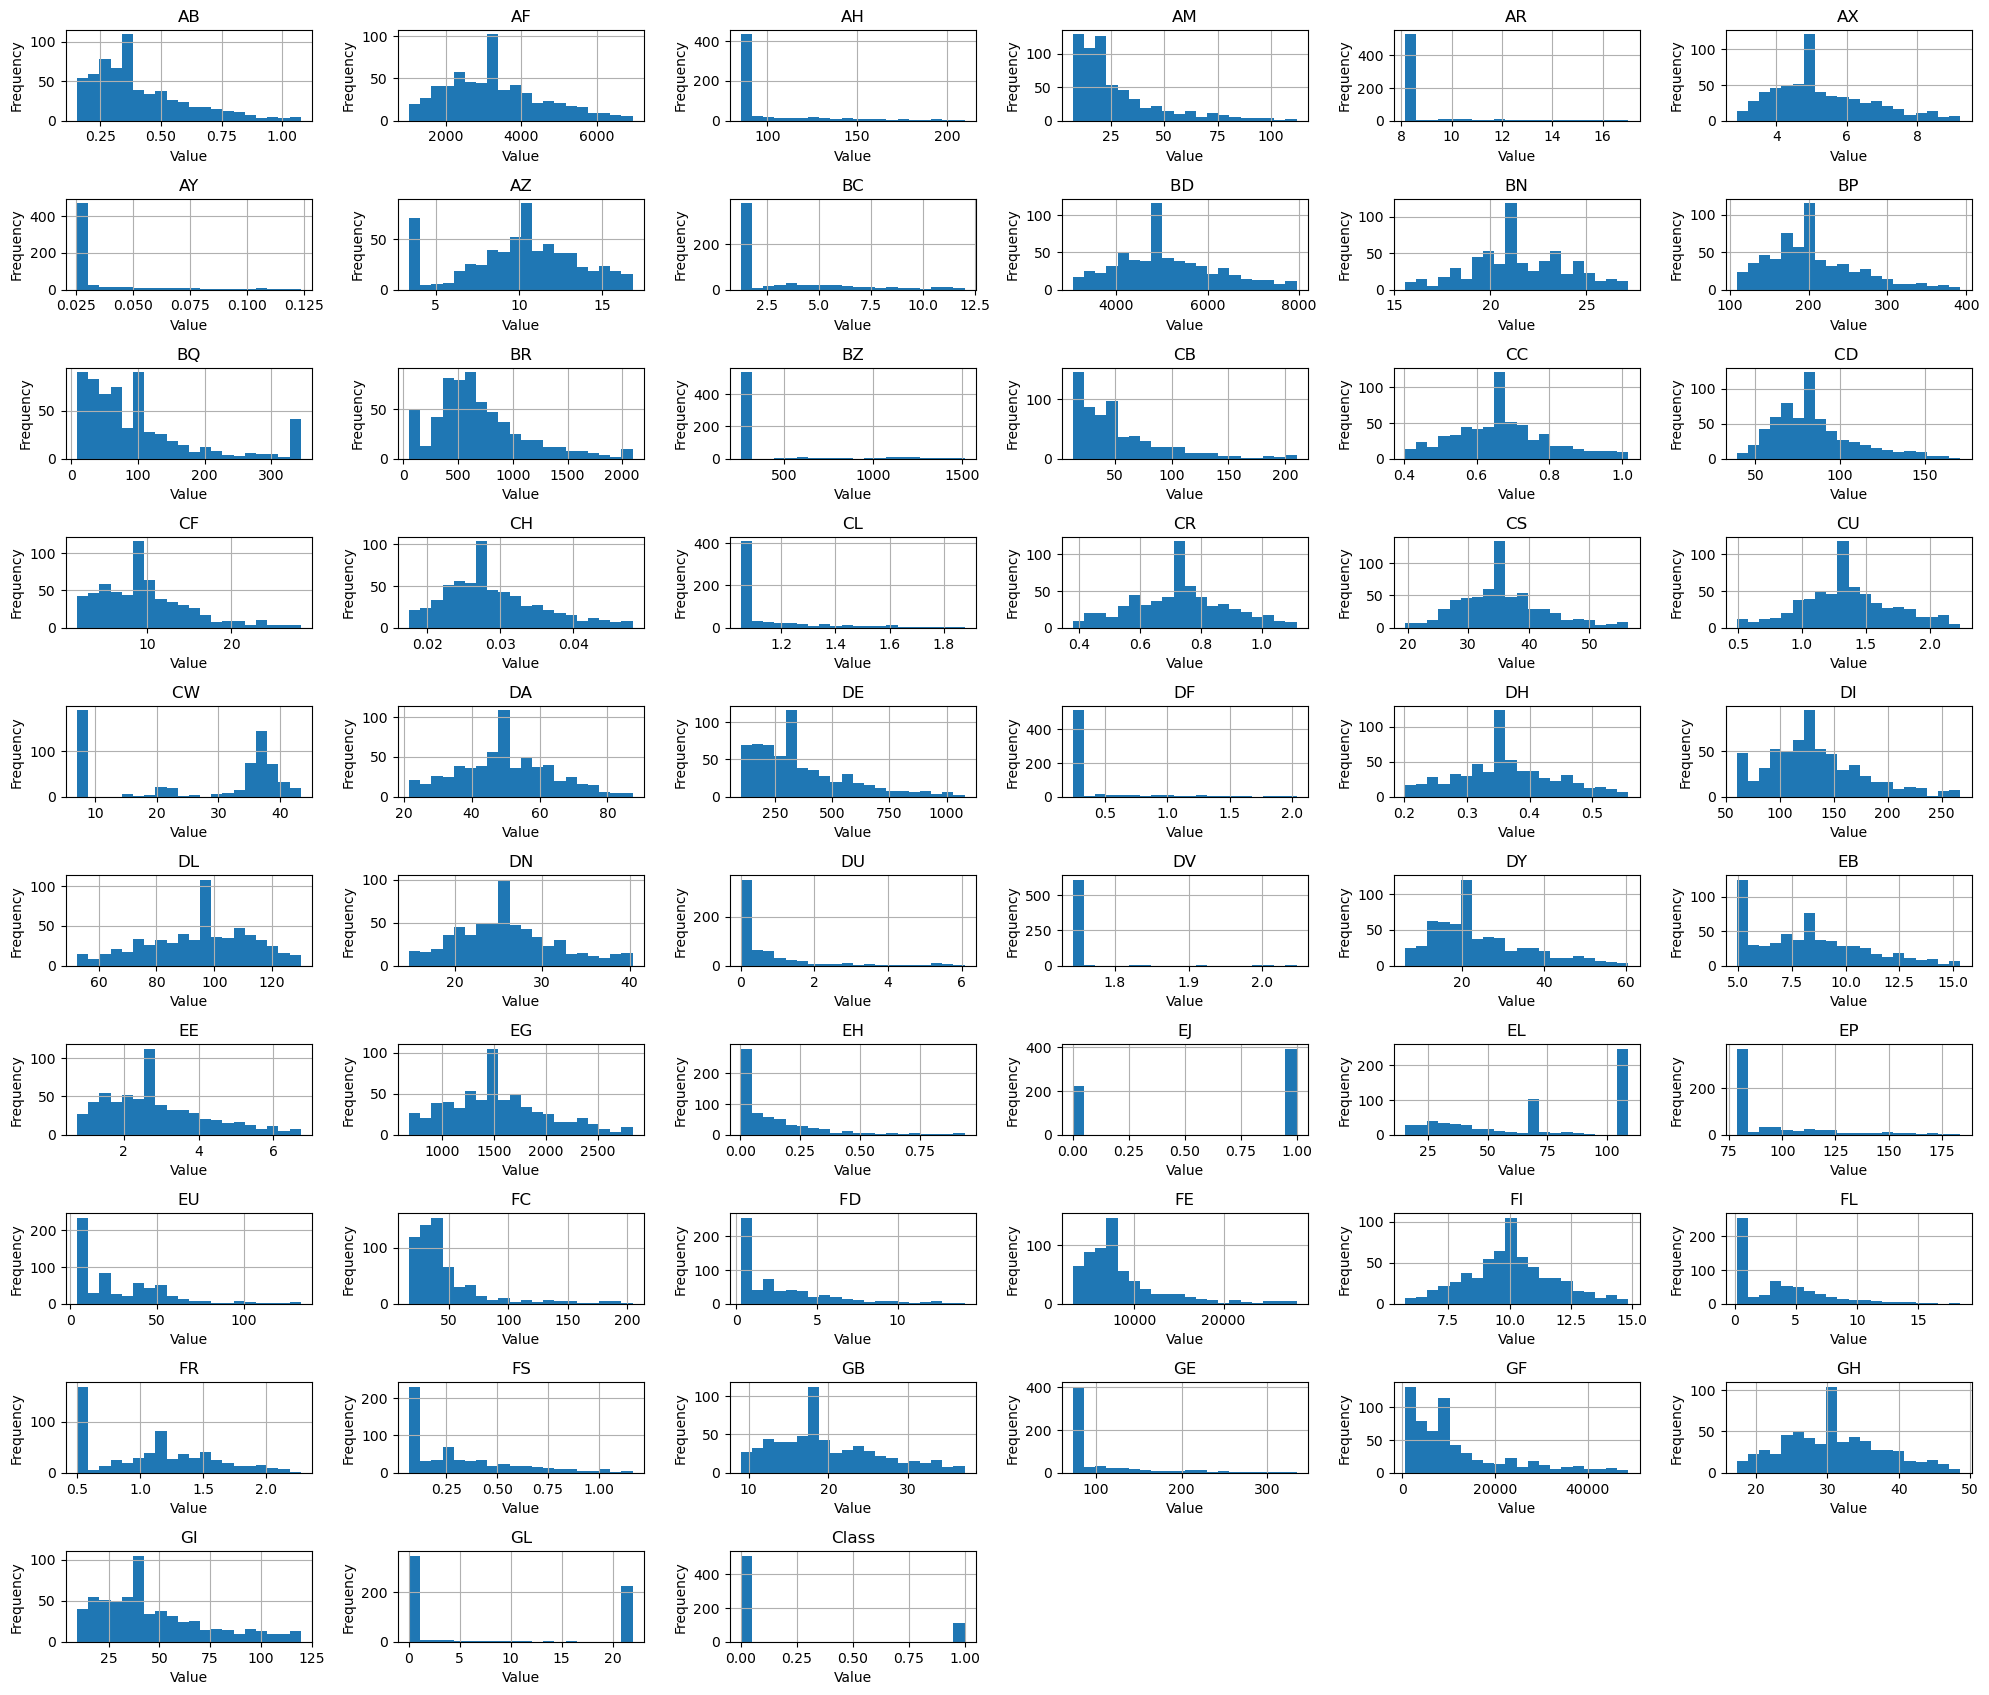

In [9]:
fig, axes = plt.subplots(12, 6, figsize=(20, 20))
axes = axes.flatten()
num_cols = len(data.columns)

for i, column in enumerate(data.columns):
    ax = axes[i]
    data[column].hist(ax=ax, bins=20)  # Adjust the number of bins as needed
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

if num_cols < len(axes):
    for j in range(num_cols, len(axes)):
        axes[j].set_visible(False)

fig.tight_layout()
plt.show()

### Data Labeling and Normalization

Columns have vastly different scales of values. For example, values in column 'GL' are on the order of 10^0, while values in column 'BD' can reach 10^4. In order to be able to compare them effectively without the columns with larger values swamping out those with smaller values, I will normalize the data.

In [10]:
min_max_df = pd.DataFrame({
                           'Minimum': data.min(),
                           'Maximum': data.max()})
print(min_max_df)

           Minimum       Maximum
AB        0.153828      1.076796
AF     1020.763260   6957.752890
AH       85.200147    209.852064
AM        7.166458    111.922483
AR        8.138688     17.027268
AX        2.870316      9.231078
AY        0.025578      0.123627
AZ        3.396778     16.845246
BC        1.229900     11.989768
BD     3042.040690   7954.676210
BN       15.536400     27.188700
BP      108.488727    392.658570
BQ        8.466250    344.644105
BR       51.216883   2095.573217
BZ      257.432377   1513.799323
CB       12.499760    210.133833
CC        0.402656      1.017413
CD       38.878912    171.197232
CF        1.651263     28.250890
CH        0.017512      0.048158
CL        1.050225      1.877675
CR        0.379650      1.113450
CS       19.516739     56.456274
CU        0.491013      2.239902
CW        7.030640     43.373768
DA       21.537880     87.429980
DE      101.257702   1078.791575
DF        0.238680      2.037906
DH        0.200876      0.557532
DI       6

In [11]:
def normalize_df(df):
    for col in df.columns:
        df[col] = df[col] / np.max(df[col])
    return df

data_norm = normalize_df(data)
data_norm = data_norm.drop('Class', axis=1)
data_norm.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.194444,0.446844,0.406001,0.200089,0.47798,0.545106,0.206897,0.582492,0.463365,0.518762,...,0.669636,0.395969,0.763597,0.081395,0.305820,0.216922,0.041117,0.455304,0.583625,0.005476
1,0.329365,0.448466,0.406001,0.330308,0.47798,0.393474,0.206897,0.802469,0.102579,0.691031,...,0.697476,0.009399,0.218316,0.488372,0.250627,0.216922,0.574162,0.599265,0.268534,1.000000
2,0.436508,0.378730,0.406001,0.289134,0.47798,0.729367,0.206897,0.761317,0.102579,0.645630,...,0.782851,0.418290,0.428480,0.220930,1.000000,0.264716,0.280642,0.576381,0.294113,0.008961
3,0.234127,0.548978,0.572792,0.688979,0.47798,0.399232,0.206897,0.656192,0.102579,0.524179,...,1.000000,0.332164,0.218316,0.244186,0.499749,0.246216,0.042973,0.821675,0.756271,0.007090
4,0.353175,0.536531,0.406001,0.126013,0.47798,0.427063,0.443350,0.201646,0.102579,0.720172,...,0.920193,0.442352,0.496752,0.104651,0.442549,0.436496,0.174914,0.933415,0.303054,0.004396


<Figure size 1000x800 with 0 Axes>

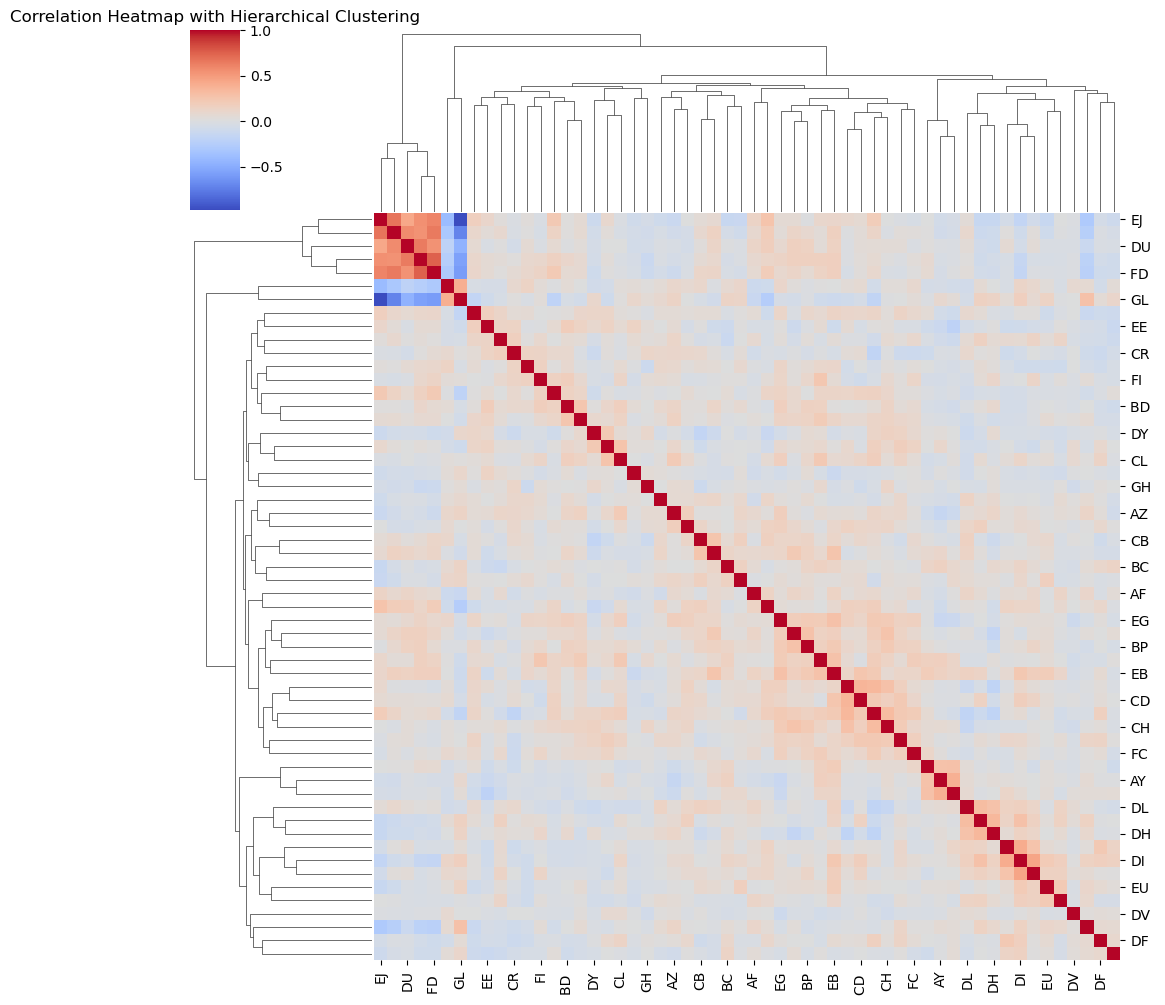

In [12]:
correlation_matrix = data_norm.corr()

# Create the hierarchical clustering heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.clustermap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap with Hierarchical Clustering")
plt.show()

### Correlations
A group of roughly seven columns are highly correlated with eachother (positively and negatively). I will combine these, and any resulting columns, into a single resulting column to minimize the effects of multiple correlations. 

In [13]:
#Combine correlated columns
corr_lim = 0.25
df_corr = data_norm.copy()
mcorr = 1
i = 0

while mcorr > corr_lim: # and i < 10:
    correlation_matrix = df_corr.corr()
    max_corr = np.abs(correlation_matrix.unstack().sort_values(ascending=False))
    column1, column2 = max_corr[max_corr != 1].index[0]
    mcorr = correlation_matrix.loc[column1, column2]
    #print("The two most correlated columns are:", column1, "and", column2)
    #print("Correlation coefficient:", mcorr, '\n')
    col_name = column1 + '_' + column2
    df_corr[col_name] = (np.abs(df_corr[column1]) + np.abs(df_corr[column2])) /2
    df_corr = df_corr.drop([column1, column2], axis=1)
    i = i + 1

print(df_corr.columns, '\n')

Index(['AF', 'AZ', 'BC', 'BQ', 'BR', 'CC', 'CF', 'CR', 'CW ', 'DA', 'DE', 'DF',
       'DN', 'DV', 'DY', 'EE', 'EL', 'EU', 'FE', 'FI', 'FS', 'GE', 'GH',
       'EJ_FL_EH_FD _DU', 'GL_GF', 'BZ_EP_AY', 'AH_CL', 'CB_FR',
       'AX_CD _AM_AB_CH_CS_EB_EG_BP_BN_FC', 'GB_BD ', 'CU_DH_DL_AR_DI_GI'],
      dtype='object') 



### Correlations pt. 2
The resulting correlations matrix shows that there is only a single pair of strongly correlated columns remaining, and correlations are down across the board. This should help reduce noise and allow the various models to more easily identify the salient features in the data.

<Figure size 1000x800 with 0 Axes>

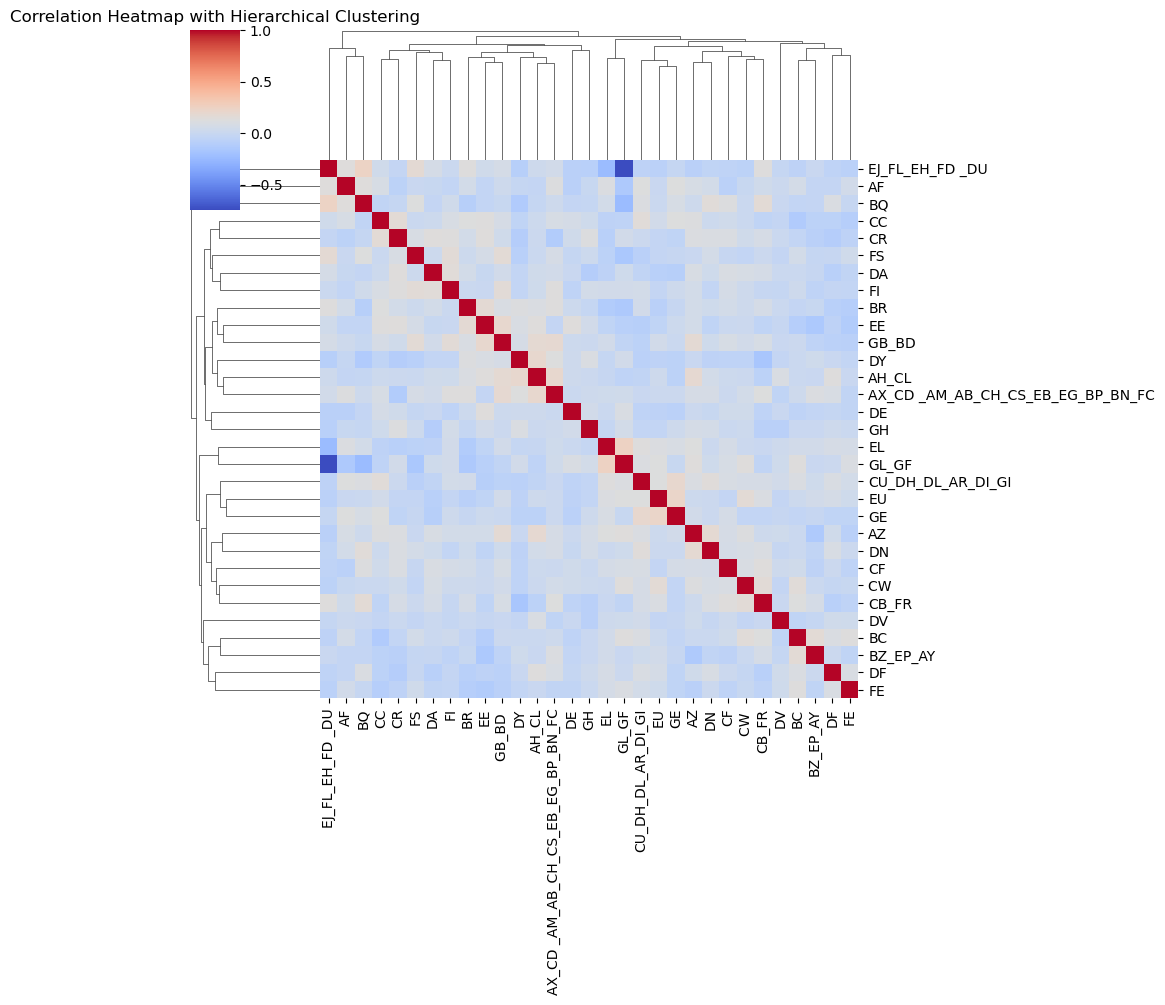

In [14]:
correlation_matrix = df_corr.corr()

# Create the hierarchical clustering heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.clustermap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap with Hierarchical Clustering")
plt.show()

In [15]:
#Create train and test data sets from normalized data and data frame with combined columns
Xn = data_norm
yn = data['Class']
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(Xn, yn, test_size=0.2, random_state=42)

X = df_corr
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling - Non-negative Matrix Factorization (NMF)

The first model I will use will be non-negative matrix factorization with a logistic regression classifier. This technique should be helpful in reducing the highly-dimensioned dataset into smaller and more manageable factorized matrices. I will use hyperparameter tuning to identify the best parameters for this model. I suspect that the model will perform better on the data with combined correlated columns, but I will also test it on the normalized data as well.

In [16]:
#hyperparameter tuning
def hyperparameter_tuning_NMF(X_train, y_train):
    warnings.filterwarnings("ignore")
    
    pipeline = Pipeline([
        ('nmf', NMF()),
        ('classifier', LogisticRegression(solver='lbfgs', max_iter=500))
    ])

    param_grid = {
        'nmf__n_components': [2,5,10],
        'nmf__solver': ['mu'],
        'nmf__beta_loss': ['frobenius', 'kullback-leibler'],
        'nmf__l1_ratio': [0, 0.5, 1]
    }
    
    scoring = make_scorer(accuracy_score)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X_train, y_train)

    warnings.filterwarnings("default")
    
    return (grid_search.best_estimator_, grid_search.best_params_)

#### NMF - Combined Columns

In [17]:
#create and fit model - combined correlated columns.
st = time.time()
(best_model, best_params) = hyperparameter_tuning_NMF(X_train, y_train)
best_params = {key: [value] for key, value in best_params.items()}
nmf_pst = time.time() - st
print('Parameter search time: ', nmf_pst)

Parameter search time:  8.154556512832642


In [18]:
pd.DataFrame(best_params)

,nmf__beta_loss,nmf__l1_ratio,nmf__n_components,nmf__solver
0,frobenius,0,2,mu


NMF accuracy:  0.8145161290322581
Prediction time:  0.008997440338134766


Text(50.722222222222214, 0.5, 'True labels')

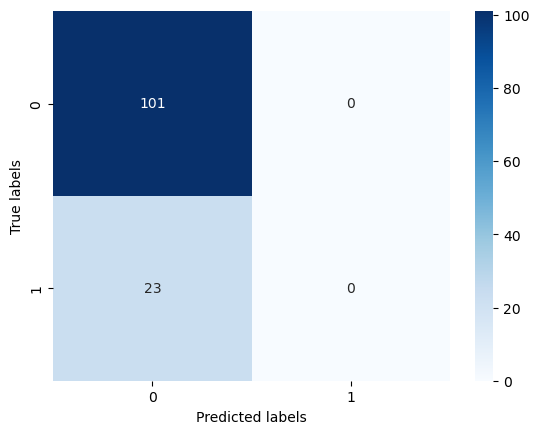

In [19]:
st = time.time()
pred = best_model.predict(X_test)
nmf_pt = time.time() - st
nmf_acc = accuracy_score(y_test, pred)
print('NMF accuracy: ', nmf_acc)
print('Prediction time: ', nmf_pt)

ax = plt.subplot()
cm_nmf = confusion_matrix(y_test, pred)
sns.heatmap(cm_nmf, annot=True, cmap='Blues', fmt='d', xticklabels = ['0', '1'], yticklabels = ['0', '1'])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

#### NMF - Normalized

In [20]:
#create and fit model
st = time.time()
(best_model_n, best_params_n) = hyperparameter_tuning_NMF(X_train_n, y_train_n)
best_params_n = {key: [value] for key, value in best_params_n.items()}
nmf_pst2 = time.time() - st
print('Parameter search time: ', nmf_pst2)

Parameter search time:  10.712548017501831


In [21]:
pd.DataFrame(best_params_n)

,nmf__beta_loss,nmf__l1_ratio,nmf__n_components,nmf__solver
0,frobenius,0,2,mu


NMF accuracy:  0.8145161290322581
Prediction time:  0.013000249862670898


Text(50.722222222222214, 0.5, 'True labels')

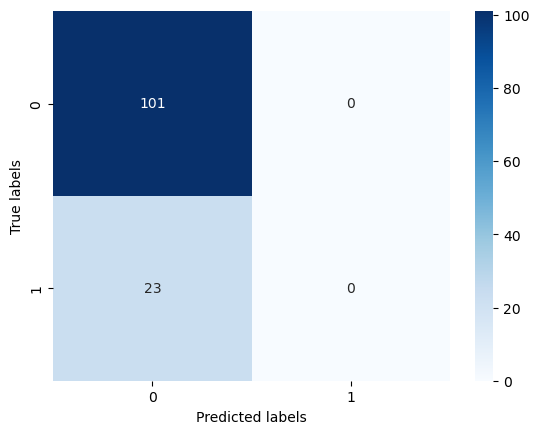

In [22]:
st = time.time()
pred2 = best_model_n.predict(X_test_n)
nmf_pt2 = time.time() - st
nmf_acc2 = accuracy_score(y_test_n, pred2)
print('NMF accuracy: ', nmf_acc2)
print('Prediction time: ', nmf_pt2)

ax2 = plt.subplot()
cm_nmf = confusion_matrix(y_test_n, pred2)
sns.heatmap(cm_nmf, annot=True, cmap='Blues', fmt='d', xticklabels = ['0', '1'], yticklabels = ['0', '1'])
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')

### NMF - Discussion
The NMF model performed similarly on the normalized data and the combined-columns data. This indicates that combining the correlated columns did not do much to help the analysis, but nor did it distort the data in such a way as to make the model less accurate.

The model achieved a moderate degree of accuracy on both data sets, roughly 81%, but looking at the confusion matrices reveals that the model was in fact classifying everything as class 0. This indicates that the model has not actually captured any of the underlying information in the dataset such that it can assist in making predictions. 

# Modeling - Multilayer Perceptron (MLP)

The next model I will use will be a multilayer perceptron (MLP). This is an unsupervised learning method that creates a network of artificial neurons arranged in layers that take in information from the previous layer, apply weights and an activation function to that input, and then send their output to the next layer. This model may be well suited to the data because unsupervised algorithms have an advantage with unsupervised features. I cannot rely on domain knowledge to help me engineer features, so I must instead rely on the algorithm to detect meaningul patterns in the data. 

That being said, there is also an increased danger of overfitting with an MLP, as this dataset is relatively small and the hyperparameters could be tuned very finely until the desired result is achieved. Overfitting the model on the training data would make it less accurate when used on different datasets. 

I will train and fit an MLP model on both the normalized and combined-columns data, as with the NMF models.

### MLP - Combined Columns

In [24]:
mlp = MLPClassifier()
warnings.filterwarnings("ignore")

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive'],
}

grid_search = GridSearchCV(mlp, param_grid, cv=5)
st = time.time()
grid_search.fit(X_train, y_train)
mlp_pst = time.time() - st
print('Parameter search time: ', mlp_pst)

Parameter search time:  87.3936653137207


In [25]:
# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
st = time.time()
y_pred = best_model.predict(X_test)
mlp_pt = time.time() - st

print("Classification Report:")
c = classification_report(y_test, y_pred)
print(c)
mlp_acc = float(classification_report(y_test, y_pred, output_dict=True)['accuracy'])

warnings.filterwarnings("default")

Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best Score: 0.8661100803957946
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91       101
         1.0       0.60      0.52      0.56        23

    accuracy                           0.85       124
   macro avg       0.75      0.72      0.73       124
weighted avg       0.84      0.85      0.84       124



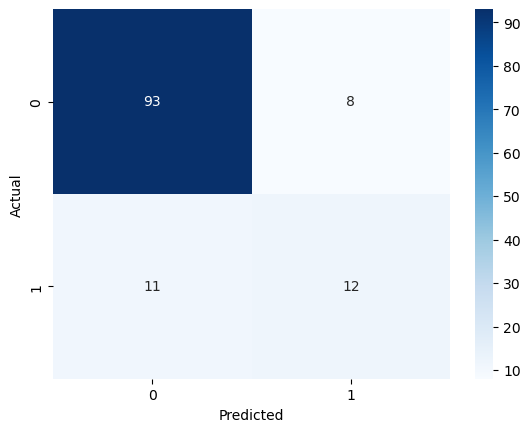

In [26]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### MLP - Normalized

In [27]:
mlp_n = MLPClassifier()
warnings.filterwarnings("ignore")

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive'],
}

# Perform grid search using cross-validation
grid_search_n = GridSearchCV(mlp_n, param_grid, cv=5)
st = time.time()
# Fit the grid search to the training data
grid_search_n.fit(X_train_n, y_train_n)
mlp_pst2 = time.time() - st
print('MLP parameter search time: ', mlp_pst2)

MLP parameter search time:  106.31691241264343


In [28]:
# Get the best parameters and score
best_params_n = grid_search_n.best_params_
best_score_n = grid_search_n.best_score_

print("Best Parameters:", best_params_n)
print("Best Score:", best_score_n)

# Evaluate the best model on the test data
best_model_n = grid_search_n.best_estimator_
st = time.time()
y_pred_n = best_model_n.predict(X_test_n)
mlp_pt2 = time.time() - st

print("Classification Report:")
c2 = classification_report(y_test_n, y_pred_n)
print(c2)
mlp_acc2 = float(classification_report(y_test_n, y_pred_n, output_dict=True)['accuracy'])

warnings.filterwarnings("default")

Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best Score: 0.8822716965574108
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       101
         1.0       0.76      0.70      0.73        23

    accuracy                           0.90       124
   macro avg       0.85      0.82      0.83       124
weighted avg       0.90      0.90      0.90       124



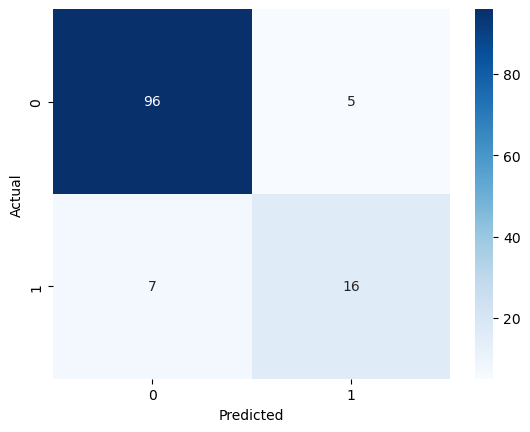

In [29]:
# Create a confusion matrix
cm = confusion_matrix(y_test_n, y_pred_n)

# Display the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### MLP - Discussion
The MLP model performed better on the normalized than on the combined-columns data. This is evidence that combining the correlated columns did not do much to help the analysis, and may have in fact been counterproductive.

The model achieved a higher degree of accuracy comapred to that of the NMF model, classifying roughly 90% of the data points correctly. It also had a better distribution of type I and type II errors. This indicates that the model is actually gleaning some predictive information from the dataset, and gives some hope that, with further tuning, the model could be made even more accurate.

# Modeling - Linear Models

Finally, I will test a linear model and generalised additive model on the combined columns and normalized data. I predict that these will perform more poorly then both the NMF and the MLP models, as it is unlikely that the 'Class' target variable is linearly dependent on any combination of the feature columns. However, these models will be useful as a comparison to the more advanced models, and serve as a benchmark to see how much the other, more sophisticated models improve over this baseline.

### Modeling - Linear Regression

In [30]:
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [31]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 0.12281989919345072
R-squared Score: 0.18705175635019455


In [32]:
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [33]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 0.12281989919345072
R-squared Score: 0.18705175635019455


### Modeling - GAM

In [34]:
model = LinearGAM().fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 0.15354219970058333
R-squared Score: -0.016299983898479864


In [35]:
results = pd.DataFrame({'Model': ['NMF - Comb', 'NMF - Norm', 'MLP - Comb', 'MLP - Norm'],
                        'Training Time': [nmf_pst, nmf_pst2, mlp_pst, mlp_pst2],
                        'Prediction Time': [nmf_pt, nmf_pt2, mlp_pt, mlp_pt2],
                        'Accuracy': [nmf_acc, nmf_acc2, mlp_acc, mlp_acc2]
                       })

results

,Model,Training Time,Prediction Time,Accuracy
0,NMF - Comb,8.154557,0.008997,0.814516
1,NMF - Norm,10.712548,0.013000,0.814516
2,MLP - Comb,87.393665,0.012789,0.846774
3,MLP - Norm,106.316912,0.018199,0.903226


# Discussion

The NMF model performed equally well on both the combined-column and normalized data. The MLP model was strictly better thann the NMF model, having slightly increased performance on the normalized data and a significant increase in performance over the NMF model on both normalized and column-combined data. The MLP model had significantly longer training times, although that is due in part to having more hyperparameter combinations to consider. This was not a problem on this relatively small dataset, but with larger datasets the MLP training time could become prohibitive and lead to a smaller chance of finding the ideal hyperparameters. 

Both the NMF and MPL models had fast, essentially negligible, prediction times. This means that both could be used in scenarios in which real-time predictions were required. 

Finally, while the models can't be compared directly, it is clear that both the NMF and MLP models performed better, and explained more of the variance in the data, than either the linear regression model or the GAM model. A small upfront investment in training time lead to significantly better results. 

Data files and this notebook can be found here:  
https://github.com/obbrown1/Unsupervised_Final